# Lab2 - TSP EA solution

In [2096]:
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
from tqdm.auto import tqdm

In [2097]:
CITIES = pd.read_csv('cities/china.csv', header=None, names=['name', 'lat', 'lon'])

POPULATION_SIZE = len(CITIES)*5
OFFSPRING_SIZE = int(POPULATION_SIZE*0.5)
MAX_GENERATIONS = 200

# Reproducible random
rng = np.random.Generator(np.random.PCG64([POPULATION_SIZE, OFFSPRING_SIZE, MAX_GENERATIONS]))

In [2098]:
# Save for each couple save -> ( distance, index of compared city )
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)), dtype=tuple)
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = (geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km, c2.Index)
    DIST_MATRIX[c2.Index, c1.Index] = (geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km, c1.Index)

## Helper Functions

In [2099]:
def cost(path):
    circular_path = path + [path[0]]
    tot_dist = 0
    for i in range(len(circular_path)-1):
        tot_dist += DIST_MATRIX[circular_path[i],circular_path[i+1]][0]
    return tot_dist


In [2100]:
def print_path(path):
    circular_path = path + [path[0]]
    print("Path:")
    for i in range(len(circular_path)-1):
        print(f"{CITIES.at[circular_path[i],'name']} -> {CITIES.at[circular_path[i+1],'name']} ({DIST_MATRIX[circular_path[i],circular_path[i+1]][0]:.2f}km)")

    print(f"\nNumber of steps: {len(circular_path)-1} , Total lenght: {cost(path):.2f} km")


In [2101]:
def visualize_path(path):
    circular_path = path + [path[0]]
    x_coordinates = [CITIES.at[i,'lon'] for i in circular_path]
    y_coordinates = [CITIES.at[i,'lat'] for i in circular_path]

    plt.figure()
    plt.title("Path EA Resolution")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.axis('equal')
    plt.plot(x_coordinates,y_coordinates,marker='o', linestyle='-', color='b')
    plt.show()

In [2102]:
@dataclass
class Individual:
    genome: list
    fitness: float = None

In [2103]:
def parent_selection(population):
    candidates = sorted(rng.choice(population,4), key=lambda e: e.fitness)
    
    return candidates[0], candidates[1]

In [2104]:
def max_distance(path):
    circular_path = path + [path[0]]
    distances = np.zeros(len(CITIES))
    for i in range(0,len(circular_path)-1):
        distances[i] = DIST_MATRIX[circular_path[i],circular_path[i+1]][0]

    return np.argmax(distances)


In [2105]:
def inverover(p1: Individual, p2: Individual):
    
    longest_dist_p2 = max_distance(p2.genome)

    index_p1 = p1.genome.index(p2.genome[longest_dist_p2])

    child_genome = p1.genome.copy()
    child_genome[index_p1:] = p1.genome[index_p1:][::-1]

    return Individual(child_genome)

    

In [2106]:
def mutation(p:Individual):
    child_genome = p.genome.copy()
    x = 0
    while x < 0.7:
        longest_dist = max_distance(child_genome)
        
        exchange_i = rng.integers(0,len(CITIES)+longest_dist)
        exchange_i = exchange_i % len(CITIES)
      
        temp = child_genome[longest_dist]
        child_genome[longest_dist] = child_genome[exchange_i]
        child_genome[exchange_i] = temp
        x = rng.random()
    return Individual(child_genome)

    

In [2107]:
def compute_fast_min(start):
    # Search min algorithm
    visited = np.full(len(CITIES), False)
    curr_city_i = start
    visited[curr_city_i] = True
    path = list()
    path.append(curr_city_i)

    while not np.all(visited):

        # Find the city with minimum distance and take the correspondig index to make it the next city
        next_city_tup= np.min(DIST_MATRIX[curr_city_i,np.logical_not(visited)])
        curr_city_i = next_city_tup[1]

        path.append(curr_city_i)
        visited[curr_city_i] = True
    
    return path


# EA Resolution

In [2108]:
cities_idx = [i for i in range(len(CITIES))]

population = [Individual(compute_fast_min(i)) for i in range(len(CITIES))]

for i in population:
    i.fitness = cost(i.genome)

for _ in tqdm(range(MAX_GENERATIONS)):
    offspring = list()

    for _ in range(OFFSPRING_SIZE):
        
        p1,p2 = parent_selection(population)
        
        if rng.random() <0.5:
            o = inverover(p1,p2)
        else:
            o = mutation(p1)

        offspring.append(o)

    for i in offspring:
        i.fitness = cost(i.genome)

    population.extend(offspring)
    population.sort(key=lambda i: i.fitness)
    population = population[:POPULATION_SIZE]


100%|██████████| 200/200 [19:35<00:00,  5.88s/it]


Path:
Qixia -> Laiyang (38.68km)
Laiyang -> Laixi (18.76km)
Laixi -> Pingdu (53.61km)
Pingdu -> Laizhou (42.17km)
Laizhou -> Zhaocheng (46.72km)
Zhaocheng -> Longkou (32.95km)
Longkou -> Penglai (40.08km)
Penglai -> Yantai (66.87km)
Yantai -> Weihai (61.97km)
Weihai -> Wendeng (33.59km)
Wendeng -> Rushan (59.18km)
Rushan -> Haiyang (32.50km)
Haiyang -> Jimo (77.32km)
Jimo -> Qingdao (36.63km)
Qingdao -> Jiaozhou (37.74km)
Jiaozhou -> Gaomi (25.04km)
Gaomi -> Anqiu (50.42km)
Anqiu -> Weifang (33.17km)
Weifang -> Changyi (29.12km)
Changyi -> Shouguang (61.09km)
Shouguang -> Qingzhou (29.10km)
Qingzhou -> Yidu (2.04km)
Yidu -> Zibo (39.23km)
Zibo -> Zhoucun (18.83km)
Zhoucun -> Zhangqiu (31.46km)
Zhangqiu -> Boshan (44.53km)
Boshan -> Laiwu (35.44km)
Laiwu -> Xintai (34.49km)
Xintai -> Taian (66.59km)
Taian -> Jinan (53.25km)
Jinan -> Liaocheng (95.99km)
Liaocheng -> Linqing (53.34km)
Linqing -> Nangong (64.34km)
Nangong -> Jizhou (28.10km)
Jizhou -> Hengshui (21.50km)
Hengshui -> Shenzho

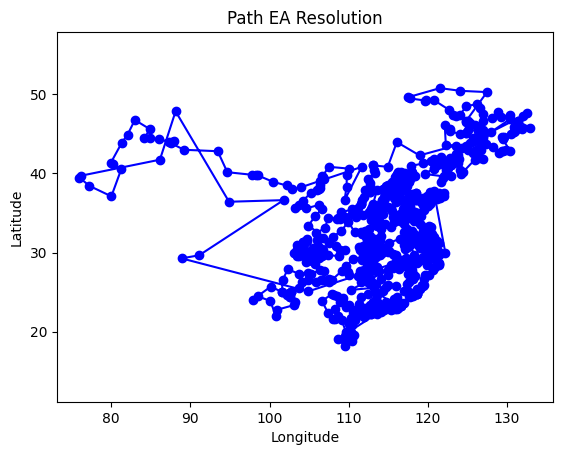

In [2109]:
print_path(population[0].genome)
visualize_path(population[0].genome)